In [1]:
import numpy as np
from labtools import time_freq_scan as tfs
import labtools as lt
from matplotlib import pyplot as plt
from matplotlib import cm
import os
from scipy.signal import find_peaks
import pandas as pd
from labtools import scanner
from scipy.optimize import curve_fit
from numpy import array
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [2]:
from ipywidgets import RadioButtons, Layout
from IPython.display import display
from ipywidgets import HBox, VBox
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
def get_most_often_linelen(d_lines, clusters=2):
    pxls  = np.array([len(i) for i in d_lines])
    whitened = whiten(pxls)
    centroids, distortion = kmeans(whitened,clusters)
    clx,_ = vq(whitened,centroids)
    clust = np.argmax([len(clx[clx==c]) for c in np.unique(clx)])
    lines_pxs = np.mean(pxls[clx == clust]).astype(int)
    return lines_pxs, pxls, clx,clust, distortion

In [4]:
folder = "/home/bbuusshh/my_git/data/dip/good_dip"

In [5]:
os.listdir(folder)

['autle_townes_real_0.dump',
 'autle_townes_real_2_1.dump',
 'autle_townes_real_nice_lower_power_0.dump',
 'autle_townes_real_nice_lower_lower_power_0.dump',
 'autle_townes_real_2_0.dump',
 'ExpI',
 'autle_townes_real_nice_0.dump',
 'autle_townes__0.dump',
 'autle_townes_real_20ms_300steps_0.dump']

In [6]:
dump_dip = "autle_townes_real_nice_0.dump"

In [7]:
data = np.fromfile(os.path.join(folder, dump_dip),count=int(1e8), dtype=lt.DUMP_TYPE)

In [8]:
data = lt.shift_channels(data, 80000, [5])

In [9]:
np.unique(data['channel'])

array([1, 2, 3, 4, 5, 7, 8], dtype=int32)

In [10]:
data = lt.assign_trigs_to_clicks(data, pix_trigs=[7,8], return_trig=True)
trig = lt.get_trig_len(data)
# data = data[data['channel']!= 5]

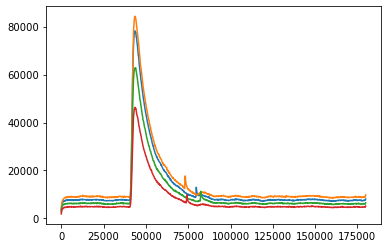

In [11]:
y, x = np.histogram(data['time_from_trig'][(data['channel']==1)], bins=1000, range=(0, trig))
plt.plot(x[:-1], y)
y, x = np.histogram(data['time_from_trig'][(data['channel']==2)], bins=1000, range=(0, trig))
plt.plot(x[:-1], y)
y, x = np.histogram(data['time_from_trig'][(data['channel']==3)], bins=1000, range=(0, trig))
plt.plot(x[:-1], y)
y, x = np.histogram(data['time_from_trig'][(data['channel']==4)], bins=1000, range=(0, trig))
plt.plot(x[:-1], y)

In [12]:
line_trig = 8
pix_trig = 7

In [13]:
d_0 = np.split(data, np.where(data['channel'] == line_trig)[0])
d_lines = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))

In [14]:
hist, times = np.histogram(data['time_from_trig'][np.isin(data['channel'], [1,2,3,4])], range=(0,trig), bins=100)

In [15]:
center = lt.get_trig_len(data, trig_ch=line_trig)/2
peak_distance_param=0.25
peak_height_param=0.5

shifts = []
errs = []
for line in d_lines:
    #line = line
    t = [int(px[0]['time']) - int(line[0][0]['time']) for px in line]
    #spectr = np.array([len(px) for px in line])
    peaksT, _ = find_peaks(hist/np.max(hist), height=0.8, distance=len(hist)/2)
    spectr = np.array([len(px) for px in line]) #np.abs(px['time_from_trig'] - times[peaksT[0]]) < 25_000
   
    peaks, _ = find_peaks(spectr/np.max(spectr), height=peak_height_param, distance=len(spectr)*0.5)
    fr = np.arange(len(spectr))

    if len(peaks)>0:
        try:
            pk = peaks[spectr[peaks].argmax()]
            popt, pcov =curve_fit(scanner.lorentz, fr, spectr, p0=[100,100,fr[pk],100])
            perr = np.sqrt(np.diag(pcov)[np.diag(pcov)>0])
            tot_err = perr.sum()
            errs.append(tot_err)

            pk = int(popt[2])
            sh = t[pk]
        except:
            pk = peaks[spectr[peaks].argmax()]
            sh = t[pk]
            errs.append(np.inf)
            continue
            print("skip")
    #plt.plot(fr,spectr)
    #plt.plot(fr[pk], spectr[pk], 'o')

    shift = sh - center
    line[0][0]['time'] = line[0][0]['time'] + shift
    #line = [px['time'] + shift for px in line]

#data2 = np.concatenate(np.concatenate(d_lines))
data = data[np.argsort(data['time'])]


In [16]:
d_0 = np.split(data, np.where(data['channel'] == line_trig)[0])
d_lines2 = np.array(list(map(lambda x: np.split(x, np.where(x['channel'] == pix_trig)[0]), d_0)))


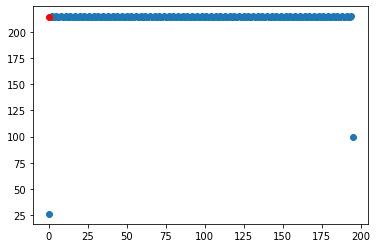

In [17]:
lines_pxs, pxls, clx,clust, distortion = get_most_often_linelen(d_lines, clusters=4)
plt.plot(pxls, 'o')
plt.plot(lines_pxs, 'ro')

In [18]:
d_lines2 = np.array(d_lines2)[clx==clust]
px_min = min(np.array([len(i) for i in d_lines2]))
px_min

194

In [19]:
binNum = 200

img = np.zeros((px_min, binNum))
for line_x in d_lines2[1:]:
    line = np.zeros(binNum)
    for px in line_x[0:px_min-1]:
        y,x = np.histogram(px['time_from_trig'], bins=binNum, range=(10, trig))
        line = np.vstack((line, y))
    img = np.dstack((img, line))

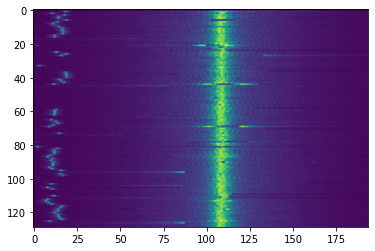

In [20]:
plt.imshow(img.sum(axis=1).T, aspect='auto')

In [21]:
import seaborn as sns

In [22]:
folder

'/home/bbuusshh/my_git/data/dip/good_dip'

In [23]:
folder_scans = os.path.join(folder, "ExpI")
scans = pd.DataFrame(os.listdir(folder_scans), columns=['Name'])

scans = scans.iloc[np.argsort(scans["Name"].apply(lambda x: int(x[-2:])))]
imgs = []
names = []
freqs = []
for scan in scans["Name"]:
    header, raw, freq = scanner.xtract(f"{folder_scans}/{scan}")
    imgs.append(raw)
    names.append(scan)
    freqs.append(freq)

In [24]:
def plot_imgs(scan):
    plt.imshow(imgs[scan], aspect='auto')
    
interact(
    plot_imgs, 
    scan = widgets.RadioButtons(
    options=range(len(scans)),
    description='Scans:',
    disabled=False,
))

interactive(children=(RadioButtons(description='Scans:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.plot_imgs(scan)>

In [25]:
len(errs)

197

In [26]:
img[:,:,:].shape

(194, 200, 129)

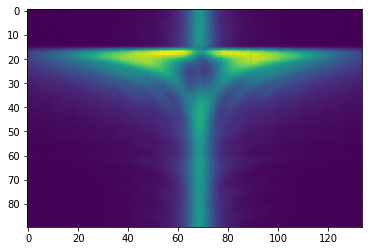

In [35]:
plt.imshow(img[40:-20,30:120,:].sum(axis=2).T, aspect='auto')

In [44]:
imm = img[40:-20,30:120,:]
trig = trig * (120 - 30)/img.shape[1]

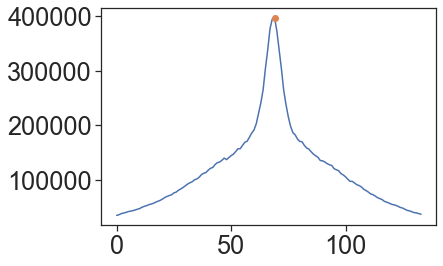

In [45]:
y = imm.sum(axis=2).T.sum(axis=0)
fr = np.arange(len(y))
peaksF, _ = find_peaks((y-min(y))/np.max(y), height=0.5, distance=len(y)*0.9)

plt.plot(fr ,y)
plt.plot(fr[peaksF] ,y[peaksF], 'o')

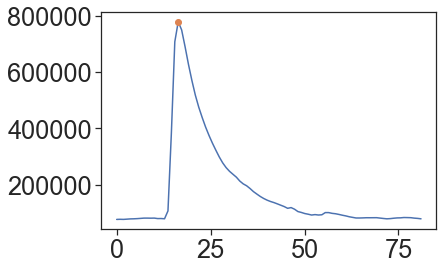

In [46]:
y = imm.sum(axis=2).T.sum(axis=1)
t = np.linspace(0, trig/1000, len(y))

peaksT, _ = find_peaks((y-min(y))/np.max(y), height=0.5, distance=len(y)*0.9)

plt.plot(t ,y)
plt.plot(t[peaksT] ,y[peaksT], 'o')

In [47]:
dfreq = (fr - fr[0])
ddd = (dfreq - dfreq[peaksF])
ddd = ddd - ddd % 2
im = pd.DataFrame(imm.sum(axis=2).T, columns=ddd)
im.index = (t - t[peaksT]).astype(int)

In [48]:
#plt.imshow(np.abs(ddd - xlabels[:,np.newaxis]), aspect='auto')

In [57]:
xlabels = np.arange(-50, 75, 25) 
xticks = [np.where(tk == min(tk))[0][0] for tk in np.abs(ddd - xlabels[:,np.newaxis])]

In [62]:
ylabels = np.arange(-10, 70, 10) 
yticks = [np.where(tk == min(tk))[0][0] for tk in np.abs((t - t[peaksT]).astype(int) - ylabels[:,np.newaxis])]

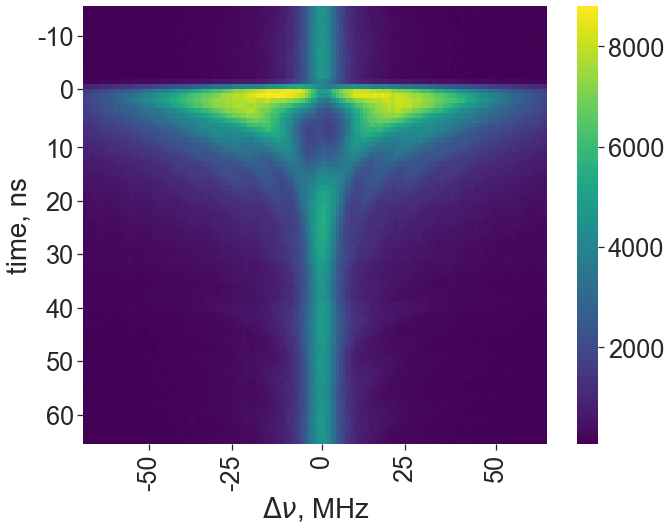

In [63]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=2.3, style='ticks', font="Arial")
ax = sns.heatmap(im,yticklabels=ylabels,xticklabels=xlabels, cmap=cm.viridis)
ax.set(xlabel=r'$\Delta \nu$, MHz', ylabel='time, ns')
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig(f"{dump_dip}.png", dpi=300)

In [106]:
y, x = np.histogram(img[:,:,:].sum(axis=2).T[8])

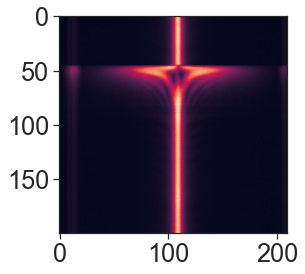

In [107]:
plt.imshow(img.sum(axis=2).T)

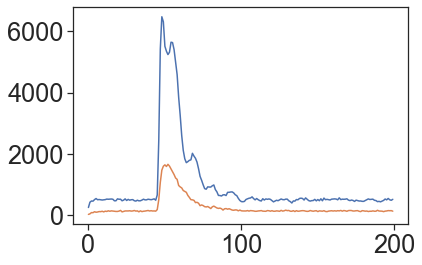

In [113]:
plt.plot(img[:,:,:].sum(axis=2)[95])
#plt.plot(img[:,:,:].sum(axis=2)[265])
plt.plot(img[:,:,:].sum(axis=2)[170])

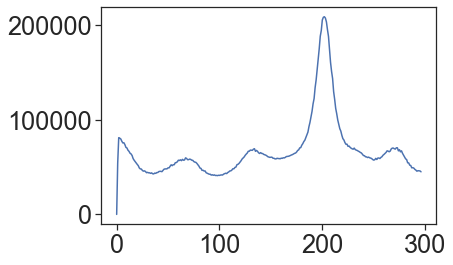

In [268]:
plt.plot(img[:,:,:].sum(axis=1).T.sum(axis=0))